In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;} </style>"))
display(HTML("<style>.CodeMirror pre {font-family: Monaco; font-size: 9pt;} </style>"))

In [0]:
n_features      = 50
n_timesteps_in  = 5
n_timesteps_out = 2

In [0]:
num_layers = 2
d_model    = 128
dff        = 512
num_heads  = 4

input_vocab_size  = n_features + 2
target_vocab_size = n_features + 2
dropout_rate      = 0.1

start_token = [n_features]
end_token   = [n_features + 1]

In [0]:
from random import randint
 
# generate a sequence of random integers
def generate_sequence(length, n_unique):
  return [randint(0, n_unique-1) for _ in range(length)]

# prepare data for the LSTM
def get_pair(n_in, n_out, n_unique):
  # generate random sequence
  temp = generate_sequence(n_in, n_unique)
  sequence_in  = start_token + temp + end_token
  sequence_out = start_token + temp[:n_out] + end_token
  
#   # one hot encode
#   X = one_hot_encode(sequence_in, n_unique)
#   y = one_hot_encode(sequence_out, n_unique)
  
#   # reshape as 3D
#   X = X.reshape((1, X.shape[0], X.shape[1]))
#   y = y.reshape((1, y.shape[0], y.shape[1]))
  
  return sequence_in, sequence_out

print(get_pair(5, 2, 50))

([50, 0, 42, 33, 18, 41, 51], [50, 0, 42, 51])


In [0]:
training = []
for _ in range(16):
  inp_ = []
  tar_ = []
  for _ in range(512):
    inp, tar = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    inp_.append(inp)
    tar_.append(tar)
  training.append((inp_, tar_))

### Transformer 

In [0]:
import tensorflow as tf
import numpy as np

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

def scaled_dot_product_attention(q, k, v, mask):
  """
    Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape   == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b = True)  # (..., seq_len_q, seq_len_k)
 
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  
  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model   = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
    
  def split_heads(self, x, batch_size):
    """
      Split the last dimension into (num_heads, depth).
      Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q) # (batch_size, seq_len, d_model)
    k = self.wk(k) # (batch_size, seq_len, d_model)
    v = self.wv(v) # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape  == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])           # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
    
    output = self.dense(concat_attention) # (batch_size, seq_len_q, d_model)
    
    return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
    tf.keras.layers.Dense(dff, activation = 'relu'), # (batch_size, seq_len, dff)
    tf.keras.layers.Dense(d_model)                   # (batch_size, seq_len, d_model)
  ])


class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate = 0.1):
    super(EncoderLayer, self).__init__()
    
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    attn_output, attn_weights_block = self.mha(x, x, x, mask)        # (batch_size, input_seq_len, d_model)
    attn_output    = self.dropout1(attn_output, training = training)
    out1           = self.layernorm1(x + attn_output)                # (batch_size, input_seq_len, d_model)
    
    ffn_output     = self.ffn(out1)                                  # (batch_size, input_seq_len, d_model)
    ffn_output     = self.dropout2(ffn_output, training = training)  
    out2           = self.layernorm2(out1 + ffn_output)              # (batch_size, input_seq_len, d_model)
    
    return out2, attn_weights_block

  
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate = 0.1):
    super(Encoder, self).__init__()
    
    self.d_model    = d_model
    self.num_layers = num_layers
    
    self.embedding    = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout    = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # (batch, seq, vocab)
    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    # adding embedding and position encoding
    x =  self.embedding(x) # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, seq_len, :]
    
    x = self.dropout(x, training = training)
    
    for i in range(self.num_layers):
      x, block = self.enc_layers[i](x, training, mask)
      
      attention_weights['encoder_layer{}_block'.format(i+1)] = block
      
    # x.shape = (batch_size, input_seq_len, d_model)
    return x, attention_weights
  
  
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate = 0.1):
    super(DecoderLayer, self).__init__()
    
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    
    self.ffn  = point_wise_feed_forward_network(d_model, dff)
    
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)                    # (batch_size, target_seq_len, d_model)
    attn1                      = self.dropout1(attn1, training = training)
    out1                       = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2                      = self.dropout2(attn2, training = training)
    out2                       = self.layernorm2(attn2 + out1)                          # (batch_size, target_seq_len, d_model)
    
    ffn_output                 = self.ffn(out2)                                         # (batch_size, target_seq_len, d_model)
    ffn_output                 = self.dropout3(ffn_output, training = training)
    out3                       = self.layernorm3(ffn_output + out2)                     # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2


class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate = 0.1):
    super(Decoder, self).__init__()
    
    self.d_model    = d_model
    self.num_layers = num_layers
    
    self.embedding    = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers   = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout      = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    seq_len           = tf.shape(x)[1]
    attention_weights = {}
    
    x =  self.embedding(x) # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, seq_len, :]
    
    x = self.dropout(x, training = training)
    
    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
    
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
      
    # x.shape = (batch_size, target_seq_len, d_model)
    return x, attention_weights


class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate = 0.1):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size,  pe_input,  rate)
    
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
    
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    # (batch_size, inp_seq_len, d_model)
    enc_output, attention_weights_e = self.encoder(inp, training, enc_padding_mask)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights_d = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    # (batch_size, tar_seq_len, target_vocab_size)
    final_output = self.final_layer(dec_output)
    
    return final_output, attention_weights_e, attention_weights_d

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_stemps = 4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    
    self.warmup_steps = warmup_stemps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
  mask  = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  
  mask  =  tf.cast(mask, dtype = loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

train_loss     = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

### Learn & Inference

In [0]:
transformer = Transformer(num_layers, 
                          d_model, 
                          num_heads, 
                          dff, 
                          input_vocab_size, 
                          target_vocab_size, 
                          pe_input = input_vocab_size, 
                          pe_target = target_vocab_size, 
                          rate = dropout_rate)

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)


def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by the decoder.
  look_ahead_mask         = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask           = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask


train_step_signature = [
  tf.TensorSpec(shape = (None, None), dtype = tf.int64),
  tf.TensorSpec(shape = (None, None), dtype = tf.int64),
]


@tf.function(input_signature = train_step_signature)
def train_step(inp, tar):
  tar_inp  = tar[:, :-1]
  tar_real = tar[:, 1: ]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask) # [None, None, 52]

    loss = loss_function(tar_real, predictions)
    
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [0]:
EPOCHS = 1024

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (inp, tar) in training:
    train_step(inp, tar)
    
  print('Epochs {} Loss {:.4f} Accuracy {:.4f}'.format(epoch, train_loss.result(), train_accuracy.result()))

TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
Epochs 0 Loss 4.4765 Accuracy 0.0133
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
TensorShape([None, None, 52])
Epo

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt

def plot_attention_weights(attention, sentence, result, layer):
  print(layer)
  
  fig = plt.figure(figsize=(16, 8))
  
  sentence = [*map(lambda x: str(x), sentence)]
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    im = ax.matshow(attention[head], cmap='viridis')
    plt.colorbar(im)
    
#     ax.matshow(attention[head][:-1, :], cmap='viridis')

#     fontdict = {'fontsize': 10}
    
#     ax.set_xticks(range(len(sentence)+2))
#     ax.set_yticks(range(len(result)))
    
#     ax.set_ylim(len(result)-1.5, -0.5)
        
#     ax.set_xticklabels(['<start>']+[i for i in sentence]+['<end>'], fontdict=fontdict, rotation=90)
#     ax.set_yticklabels([str(i) for i in result],  fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
MAX_LENGTH = 10

def evaluate(inp_sentence):
  start_token = [n_features]
  end_token   = [n_features + 1]

  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence  = start_token + inp_sentence + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0) 

  # as the target is english, the first word to the transformer should be the english start token.
  decoder_input = start_token
  output        = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    print(output)
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights_e, attention_weights_d = transformer(encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask)
    
    plot_attention_weights(attention_weights_e, sentence, None, 'encoder_layer1_block')
    plot_attention_weights(attention_weights_e, sentence, None, 'encoder_layer2_block')
    
    plot_attention_weights(attention_weights_d, sentence, None, 'decoder_layer1_block1')
    plot_attention_weights(attention_weights_d, sentence, None, 'decoder_layer1_block2')

    plot_attention_weights(attention_weights_d, sentence, None, 'decoder_layer2_block1')
    plot_attention_weights(attention_weights_d, sentence, None, 'decoder_layer2_block2')
    
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1, :]  # (batch_size, 1, vocab_size)

    print(predictions)

    predicted_id = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end_token:
      return tf.squeeze(output, axis = 0), attention_weights_e , attention_weights_d
    
    predicted_id = tf.expand_dims(predicted_id, 0)
    
    # concatentate the predicted_id to the output which is given to the decoder as its input.
    output = tf.concat([output, predicted_id], axis = -1)
    
  return tf.squeeze(output, axis = 0), attention_weights_e, attention_weights_d

tf.Tensor([[50]], shape=(1, 1), dtype=int32)
encoder_layer1_block


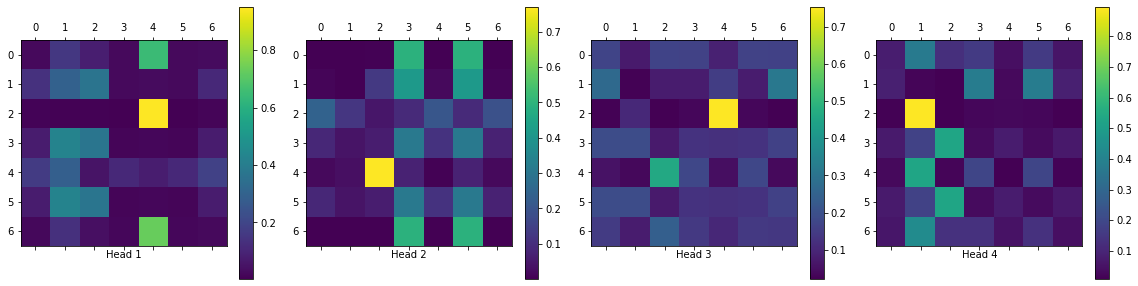

encoder_layer2_block


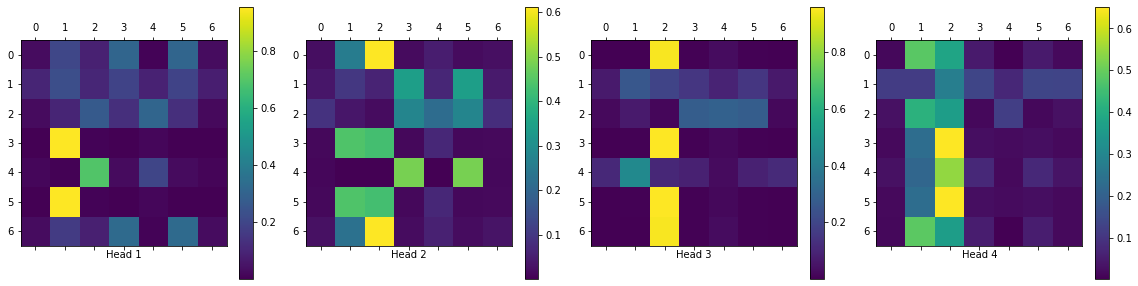

decoder_layer1_block1


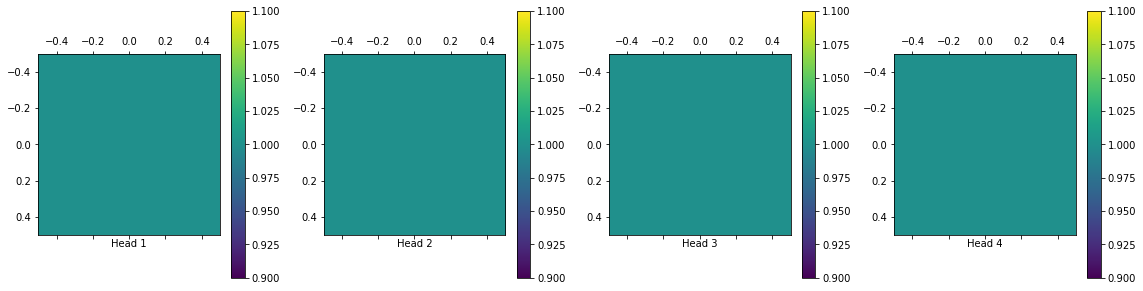

decoder_layer1_block2


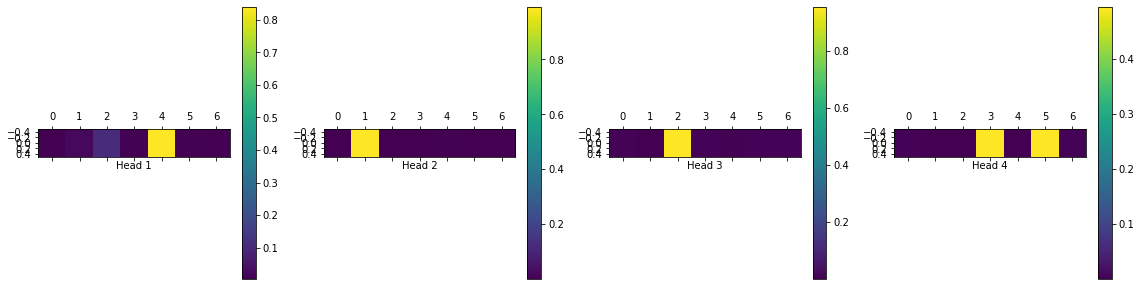

decoder_layer2_block1


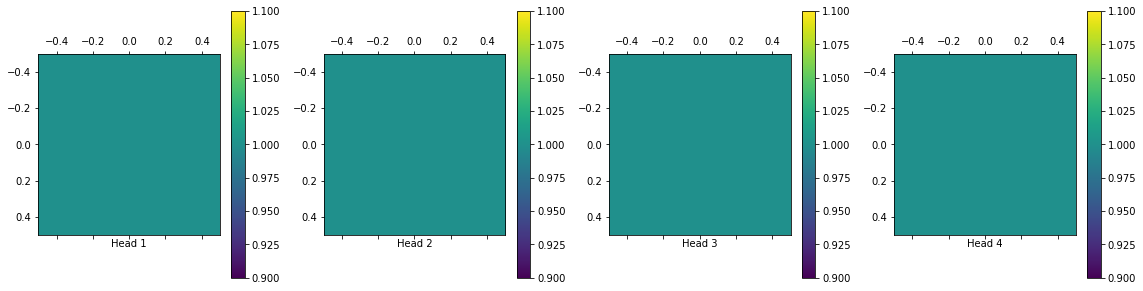

decoder_layer2_block2


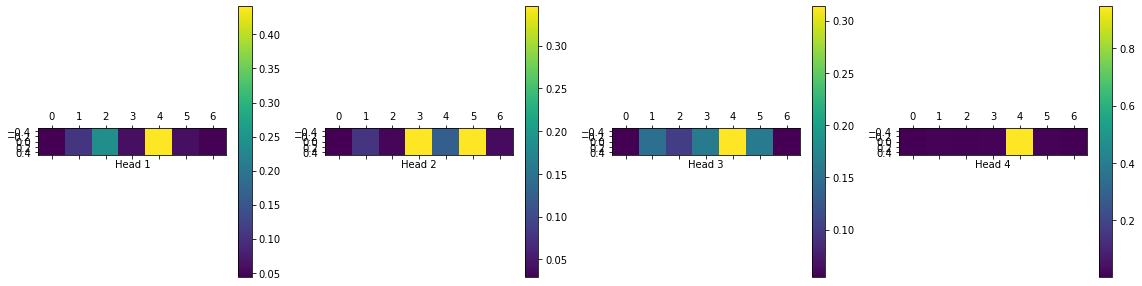

tf.Tensor(
[[ -9.436257    -6.486126    -3.8058136   -5.3706512    1.6957117
   -4.084618    -4.6581273    1.0065469   -0.86088246  -3.4535577
    2.2252219  -12.185187    18.052923    -2.785058     4.454569
    4.5590835   -2.0044854   -8.466736     0.3844174   -3.2941756
   18.84816      2.4791543   -4.5279546   -5.6117682   -3.3295343
   -1.1987841   -3.7167883   11.833478     0.8646832  -10.538835
   -2.007976     9.038718    -4.671892    14.414096     0.4463041
   -5.642263    -2.174495     3.839621     0.80463773  -6.7856574
    1.6201456    5.1225123   -9.789594     3.7050908    1.1681895
    2.187079     0.42754298   2.5233912   -2.8235092   -4.6217523
   -9.622823     0.575974  ]], shape=(1, 52), dtype=float32)
tf.Tensor([[50 20]], shape=(1, 2), dtype=int32)
encoder_layer1_block


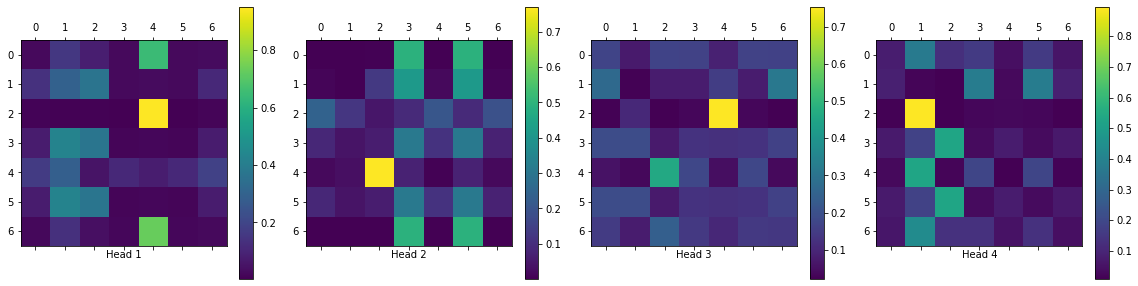

encoder_layer2_block


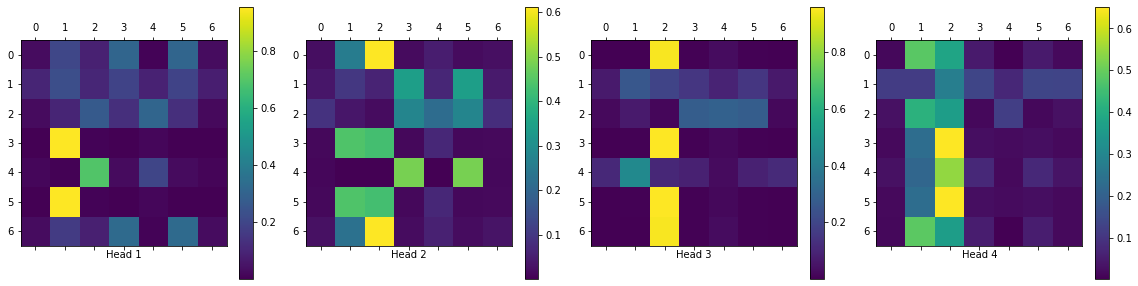

decoder_layer1_block1


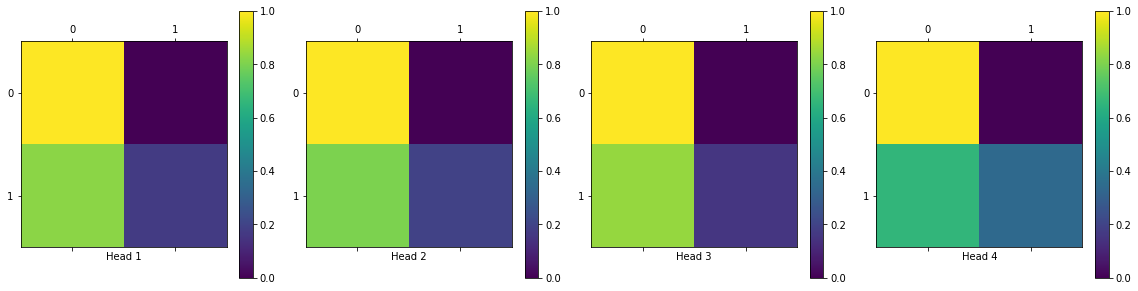

decoder_layer1_block2


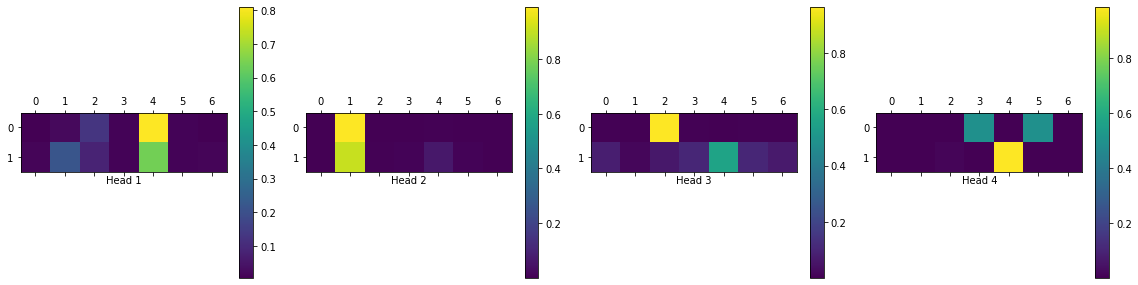

decoder_layer2_block1


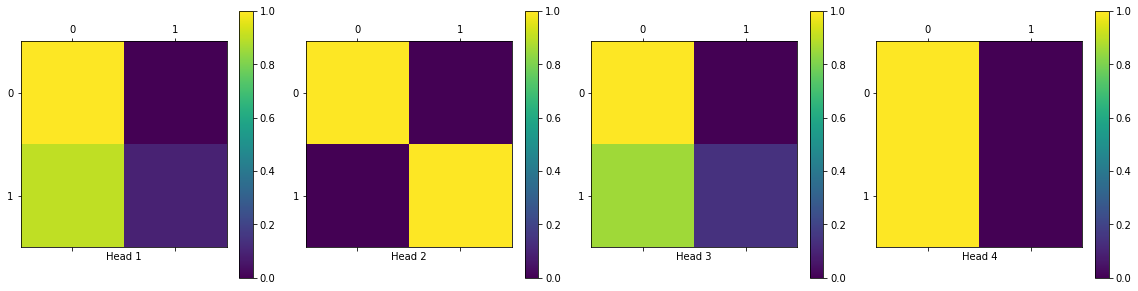

decoder_layer2_block2


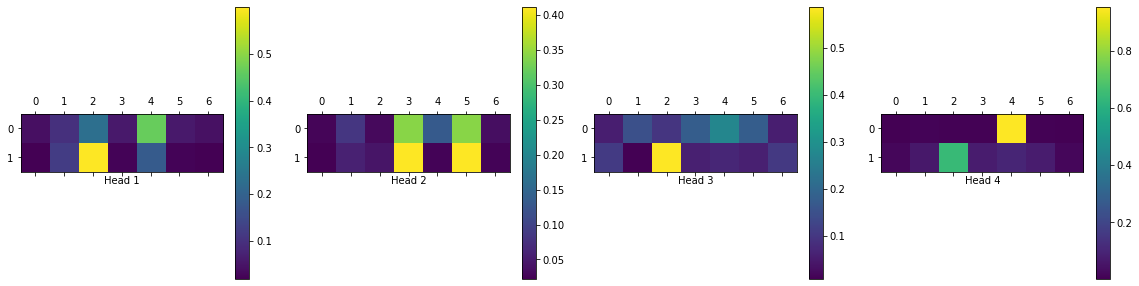

tf.Tensor(
[[-12.089891     2.3690157   -1.7677661    6.6294546    1.9424769
   -5.17494     -7.3740716   -3.317924    -3.406896    -0.50570405
    3.5815194   -5.222168    18.919733     3.5964117   -4.8683395
    7.1352997   -0.48211592  -0.44722566  -8.994247    -2.592153
   -0.7257433   -6.651265    -4.4492173   -3.9427235  -10.153252
   -3.5583255   -2.31258     14.684317    -0.27071676  -5.1839046
    1.6942548   -4.3205833   -4.742926    14.457792     1.9921732
    4.4928274    7.385076    -9.210821     0.65835243  -9.242777
    4.398546     5.556955    -5.071193     9.845495     3.188873
   -4.244927    -2.0555084   -1.4049791   -1.9227628    4.3532763
  -12.239643     6.1031294 ]], shape=(1, 52), dtype=float32)
tf.Tensor([[50 20 12]], shape=(1, 3), dtype=int32)
encoder_layer1_block


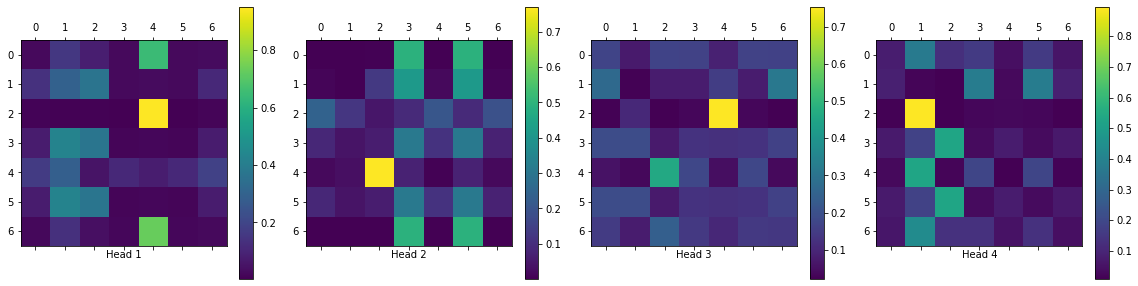

encoder_layer2_block


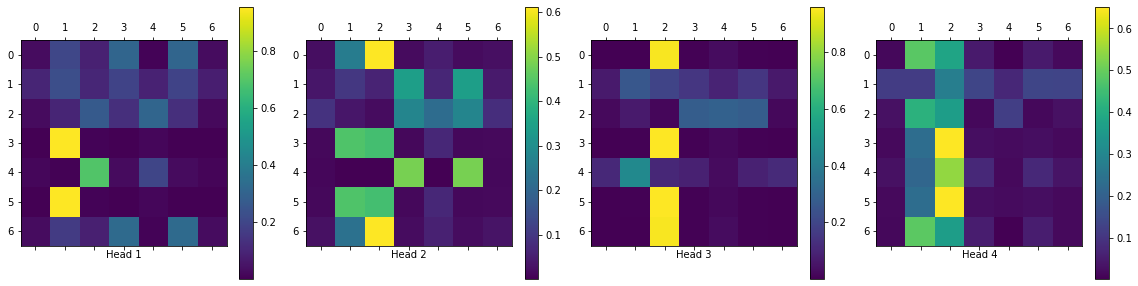

decoder_layer1_block1


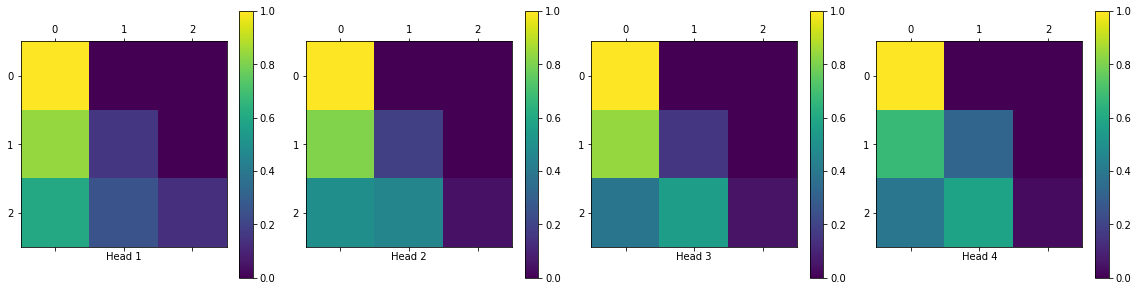

decoder_layer1_block2


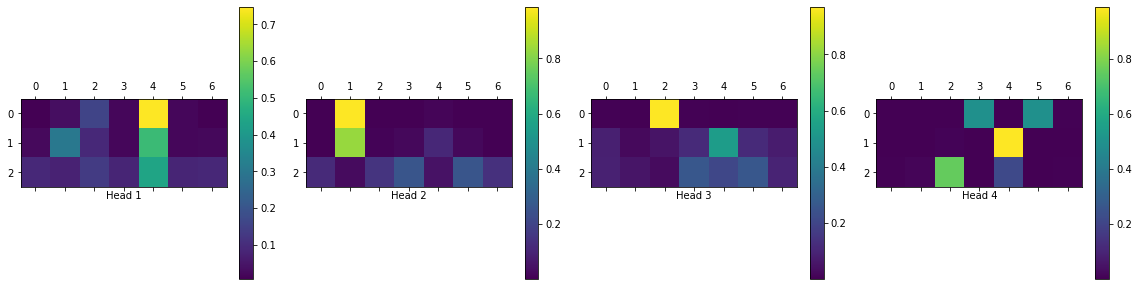

decoder_layer2_block1


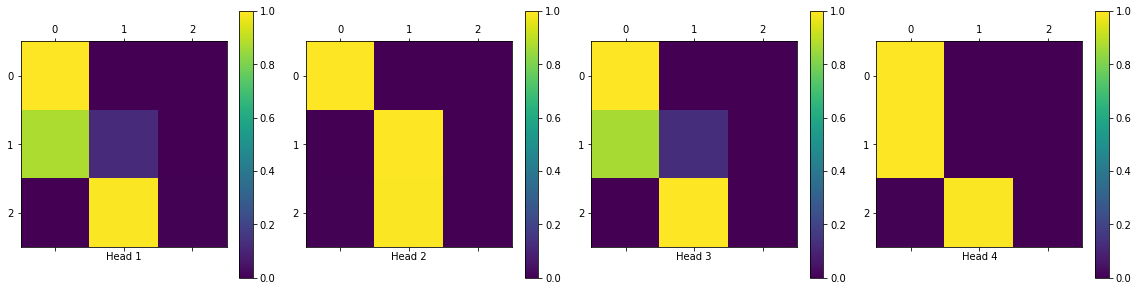

decoder_layer2_block2


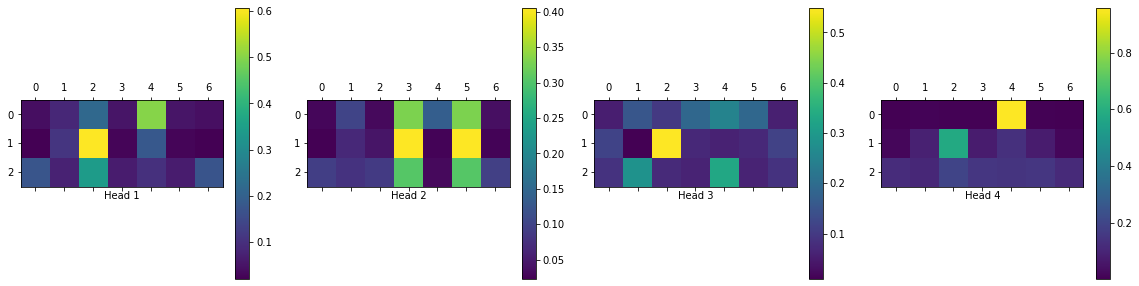

tf.Tensor(
[[-13.075472     1.3207928   -0.6431044    0.60402924  -0.5724363
    3.4609127    0.07570265   0.21235108  -1.5651755   -0.36545098
   -0.60808104  -5.46486      6.8299713   -0.60824466   3.281026
    1.8845987   -0.03262084  -0.68556464  -2.0745847    0.35900837
    4.13516     -0.9303702   -2.4347382   -3.1334064   -6.130301
   -1.8823512   -1.330326     1.8911198   -2.6945155   -2.8846085
    4.169015    -4.34757     -3.2937293    3.5867903    2.5647218
    0.85257375  -3.7949286   -4.433849     0.04253047   1.6126577
   -3.1254613    1.5269809   -5.0371666    1.4611669    2.1493192
    2.3380094   -1.3465784   -3.3323324    2.2255077   -0.64305717
  -13.032256    31.219507  ]], shape=(1, 52), dtype=float32)


In [0]:
sentence = [12, 33, 20, 27, 20]
_, _, _ = evaluate(sentence)